# Forecasting Natural Gas Prices with Exogenous Variables

## Abstract 

Natural gas has quickly become one of the most important fuels of the 21st century. It is the cleanest burning hydrocarbon, an odorless, colorless, and non-toxic gas which has a wide variety of applications. It provides warmth for cooking and heating, and fuels the power stations that provide electricity to homes and businesses. It also is a key input for many industrial processes, such as the manufacturing of glass and clothing, as well as paints, plastics, and fertilizer.

Natural gas has become increasingly adopted by the energy generation sector, creating less than 25% of all energy in the US in 2011, today accounting for about 41.1%.

Because of its wide array of uses, natural gas and its corresponding derivatives, or futures contracts, are heavily traded. Commercial buyers and speculators alike seek to identify the true value of natural gas as its price fluctuates. Our approach combines two exogenous variables: degree days, a proxy for demand, and underground storage data, a measure of supply, to build a more comprehensive price prediction model.

This project seeks to forecast natural gas prices two weeks into the future, using the cutting edge Gluon-TS library, a deep learning time series model developed at Amazon. 

## Import Libraries

In [85]:
from Libraries import *

import warnings
warnings.simplefilter('ignore');

## Load Data & Clean 

__Price Data__
>The price data contains the daily spot closing price for natural gas at Louisiana's Henry Hub, one of the most actively traded hubs, sourced from Quandl.
 
__Weather Data__
>The weather data was aggregated from the National Oceanic and Atmospheric Administration's annual degree day database. It contains population weighted HDDs (Heating Degree Days) and CDD (Cooling Degree Days) for the entire continental United States.
 
__Storage Data__
>The storage data used in this analysis comes from the Energy Information Administration. The data contains 10 years of underground storage information, calculated on a weekly basis, which we interpolate linearly to find daily totals.

In [86]:
# read all the data into separate dataframes
price_full = pd.read_csv('../data/naturalgasprices.csv')

weather = pd.read_csv('../data/weather.csv', index_col=0, parse_dates=True)
storage = pd.read_csv('../data/storage.csv', index_col=0, parse_dates=True)
spot = pd.read_csv('../data/spot.csv', index_col=0, parse_dates=True)

### Weather 

In [87]:
weather.head()

,HDD,CDD
Date,,
2011-01-07,30,0
2011-01-08,33,0
2011-01-09,35,0
2011-01-10,36,0
2011-01-11,36,0


### Storage 

In [88]:
storage.head()

,CONUS
Date,
2011-01-07,2960
2011-01-14,2716
2011-01-21,2543
2011-01-28,2355
2011-02-04,2144


### Price

In [89]:
spot.head()

,Spot
Date,
2010-01-07,7.51
2010-01-08,6.56
2010-01-11,5.77
2010-01-12,5.57
2010-01-13,5.61


#### Full Price Data

In [90]:
price_full.head()

,Date,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
0,12/4/2020,2.511,2.623,2.462,2.553,0.068,2.575,140379,297838
1,12/3/2020,2.760,2.768,2.484,2.512,-0.273,2.507,264650,298896
2,12/2/2020,2.881,2.934,2.740,2.756,-0.100,2.780,142057,297401
3,12/1/2020,2.934,2.972,2.833,2.876,-0.002,2.880,134920,297347
4,11/30/2020,2.831,2.996,2.823,2.934,0.039,2.882,136195,295779


In [91]:
# drop open interest & settle columns, convert date column string to datetime
price_full = price_full[['Date','Last','Volume','Open','High','Low']]
price_full['Date'] = pd.to_datetime(price_full['Date'])

In [92]:
# reverse sort order and set datetime column as index
price_full = price_full.sort_index(ascending=False)
price_full.set_index('Date', inplace=True)
price_full = price_full.interpolate(method='linear', axis=0)

price_full.head()

,Last,Volume,Open,High,Low
Date,,,,,
1990-04-03,1.635,240,1.580,1.655,1.580
1990-04-04,1.620,84,1.620,1.650,1.599
1990-04-05,1.615,57,1.615,1.635,1.610
1990-04-06,1.625,62,1.615,1.635,1.610
1990-04-09,1.637,37,1.612,1.640,1.612


## Merged Data

Combining the separate dataframes into one complete dataframe, aligned on the datetime index.

In [93]:
# join weather + storage and interpolate the weekly storage data linearly
merged = weather.merge(storage, how='outer', left_index=True, right_index=True)
merged_fill = merged.interpolate(method='linear', axis=0)

merged_fill.head(2)

,HDD,CDD,CONUS
Date,,,
2011-01-07,30,0,2960.000000
2011-01-08,33,0,2925.142857


In [94]:
# add spot to the combined dataframe and fill missing weekend values with interpolation
full_fill = merged_fill.join(spot)
full_df = full_fill.interpolate(method='linear', axis=0)

full_df.tail(2)

,HDD,CDD,CONUS,Spot
Date,,,,
2020-12-24,25,0,3476.285714,2.68
2020-12-25,28,0,3460.000000,2.62


In [95]:
# create a temperature column for the calendar visualization
full_df['Year'] = full_df.index.year

full_df['Base_Temp'] = 65

## Exploratory Visualizations

### Historical Price Chart 

In [96]:
# resample daily data into monthly data
monthly = price_full.resample('M').agg({'Open':'first', 'High':'max', 
                                      'Low': 'min', 'Last':'last'})

In [97]:
# creates a candlestick chart with OHLC monthly candles
fig = go.Figure(data=[go.Candlestick(x=monthly.index,
                open=monthly['Open'], high=monthly['High'],
                low=monthly['Low'], close=monthly['Last'])])
# create title
fig.update_layout(
    title={
        'text': 'Natural Gas Historical Prices',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        font=dict(
        size=12))


# creates zoom feature on y-axis
fig.update_yaxes(fixedrange = False)

# creates year buttons & x-axis slider
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label='1y', step='year', stepmode='backward'),
            dict(count=3, label='3y', step='year', stepmode='backward'),
            dict(count=5, label='5y', step='year', stepmode='backward'),
            dict(count=10, label='10y', step='year', stepmode='backward'),
            dict(step='all')]
        )
    )
)

fig.show()

### Volume Chart

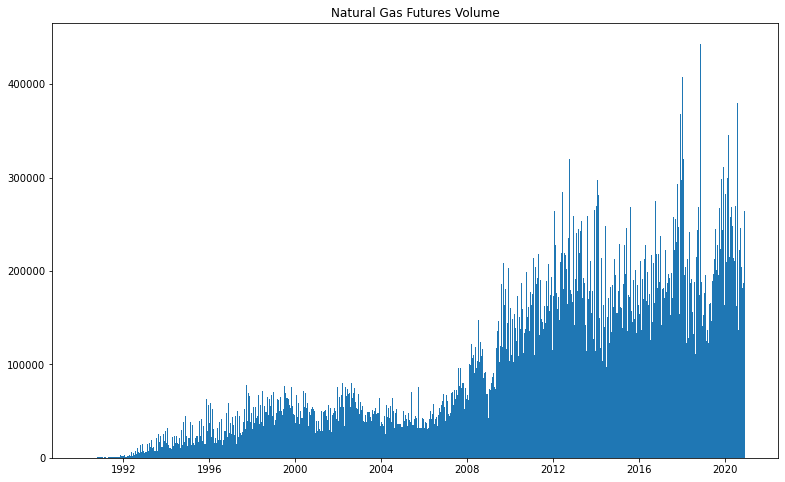

In [114]:
fig, ax = plt.subplots(figsize=(13,8))

date = price_full.index
volume = price_full['Volume']

ax.set_title('Natural Gas Futures Volume')

ax.bar(date, volume, width=10);

We can see daily trading volume really starting to ramp up in the 2010's, which is the period that this analysis primarily focuses on.

### Stationarity Check

#### Augmented Dickey Fuller Test 

In [15]:
from statsmodels.tsa.stattools import adfuller

ADF_series = full_df['Spot'].values
result = adfuller(ADF_series)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.132171
p-value: 0.024262
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


p-value < 0.05, we reject the null hypothesis -- the series is stationary.

#### Autocorrelation Function 

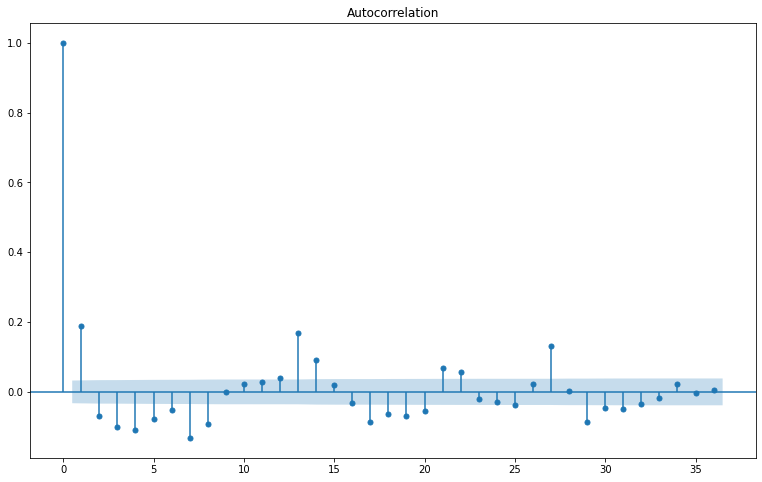

In [16]:
mpl.rcParams['figure.figsize'] = (13, 8)
mpl.rcParams['axes.grid'] = False

plot_acf(full_df['Spot'].diff(1).dropna());

#### Partial Autocorrelation Function 

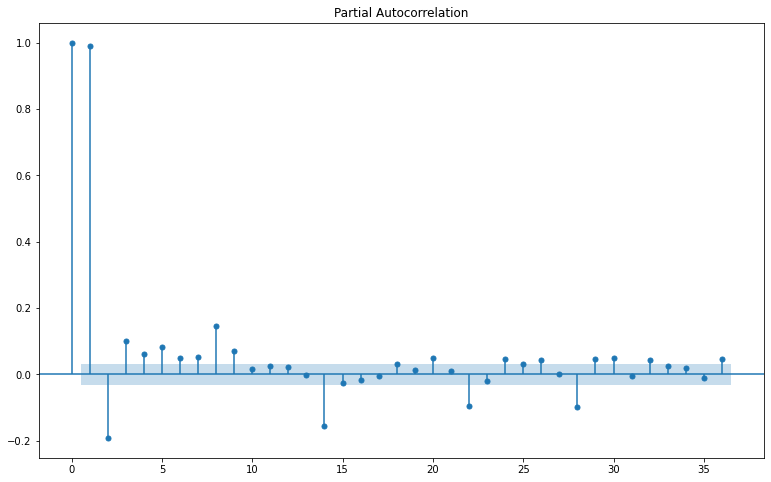

In [17]:
plot_pacf(full_df['Spot'].dropna());

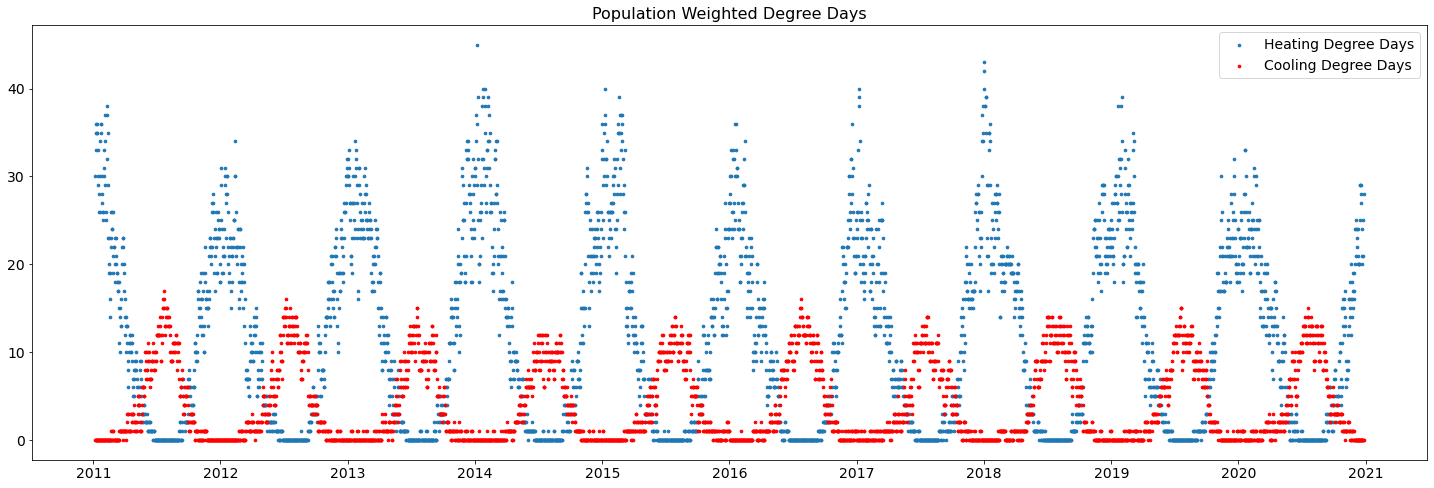

In [18]:
fig, ax = plt.subplots(figsize=(25,8))
    
ax.scatter(full_df.index, full_df['HDD'], s=7, label='Heating Degree Days')
ax.scatter(full_df.index, full_df['CDD'], color='r', s=7, label='Cooling Degree Days')

ax.set_title('Population Weighted Degree Days', fontsize=16)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

ax.legend(bbox_to_anchor=[1,1], fontsize=14);

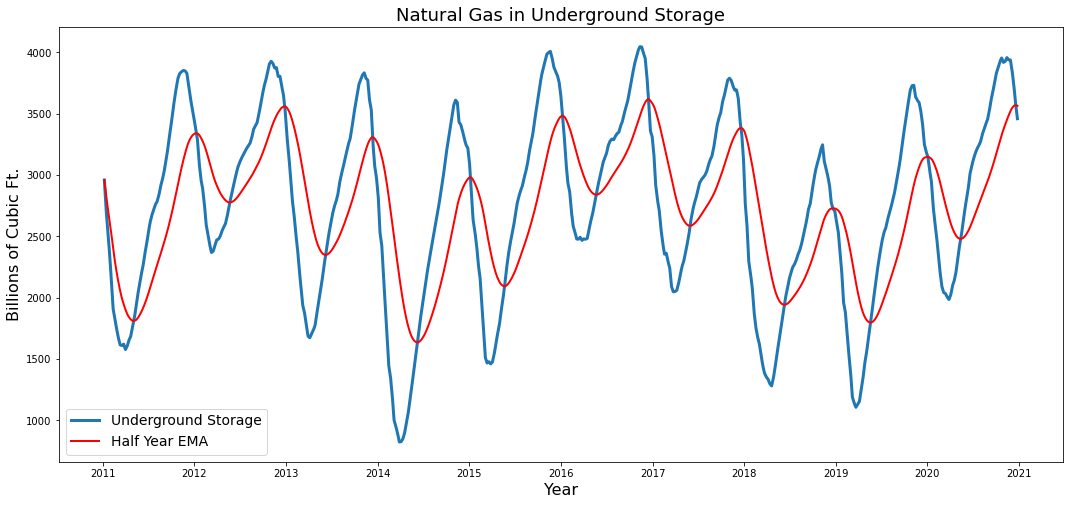

In [19]:
fig, ax = plt.subplots(figsize=(18,8))

# create a simple moving average
half_yr_simple_high = full_df['CONUS'].rolling(window=183).max()
half_yr_simple_low = full_df['CONUS'].rolling(window=183).min()
average = (half_yr_simple_high + half_yr_simple_low) / 2

#create an exponential moving average
exponential_moving_average = full_df['CONUS'].ewm(span=183).mean()
    
ax.plot(full_df['CONUS'], label='Underground Storage', linewidth=3)
#ax.plot(average, label='Half Year Moving Average', color='green', linewidth=2)
ax.plot(exponential_moving_average, label='Half Year EMA', color='red', linewidth=2)

ax.set_title('Natural Gas in Underground Storage', fontsize=18)

ax.set_ylabel('Billions of Cubic Ft.', fontsize=16)
ax.set_xlabel('Year', fontsize=16)

ax.legend(fontsize=14);

### Correlation Matrix 

#### Prepare Correlation Matrix 

In [115]:
# creates a new dataframe to be used in constructing the correlation matrix
corr_df = full_df.drop(['Base_Temp','Year'], axis=1)

corr_df = corr_df[['Spot', 'CONUS', 'HDD', 'CDD']]

corr_df.columns=[column.replace('CONUS','Storage') for column in corr_df.columns]

In [21]:
# converts all the values in the columns to z-scores
mean_df = corr_df.mean()
std_df = corr_df.std()

z_score_df = (corr_df - mean_df) / (std_df)

z_score_df.head()

,Spot,Storage,HDD,CDD
Date,,,,
2011-01-07,1.593547,0.268427,1.778232,-0.877598
2011-01-08,1.621117,0.223300,2.061033,-0.877598
2011-01-09,1.648688,0.178173,2.249567,-0.877598
2011-01-10,1.676258,0.133046,2.343834,-0.877598
2011-01-11,1.593547,0.087919,2.343834,-0.877598


In [22]:
# builds a correlation matrix for the z-scored columns
correlation = z_score_df.corr()

#### Display Matrix

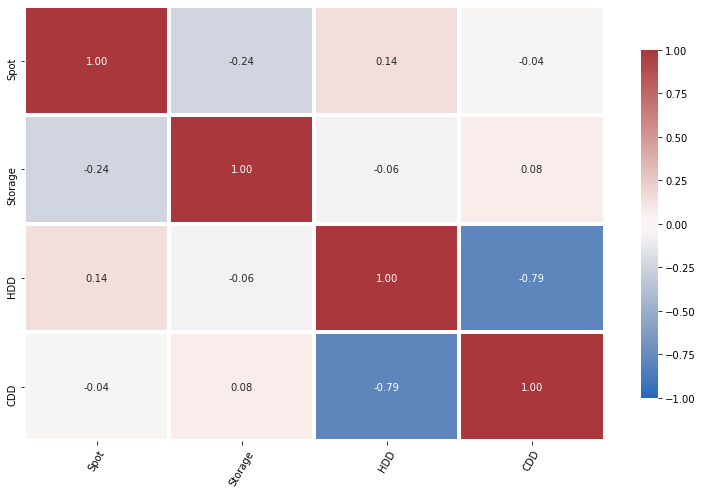

In [23]:
# creates the figure and axis for the subplots
fig, ax = plt.subplots(figsize=(13, 8))

# plots heatmap
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='vlag', linewidths=3, vmin=-1.0, vmax=1.0, cbar_kws={"shrink": .8})

# xtick adjustment
plt.xticks(rotation=60)
plt.show()

### Calendar Visualization

#### Create Aggregate Temperature

In [24]:
# creates conditions necessary to calculate the 'Temp' column
conditions = [
             (full_df['HDD'] >= full_df['CDD']),
             (full_df['CDD'] > full_df['HDD'])
             ]

# create a list of the values to assign to each condition
values = [full_df['Base_Temp'] - full_df['HDD'], full_df['Base_Temp'] + full_df['CDD']]

# create a new column and use np.select to assign values to it using the arguments
full_df['Temp'] = np.select(conditions, values)

In [25]:
Temp = pd.Series(full_df.Temp)

#### Display Calendar 

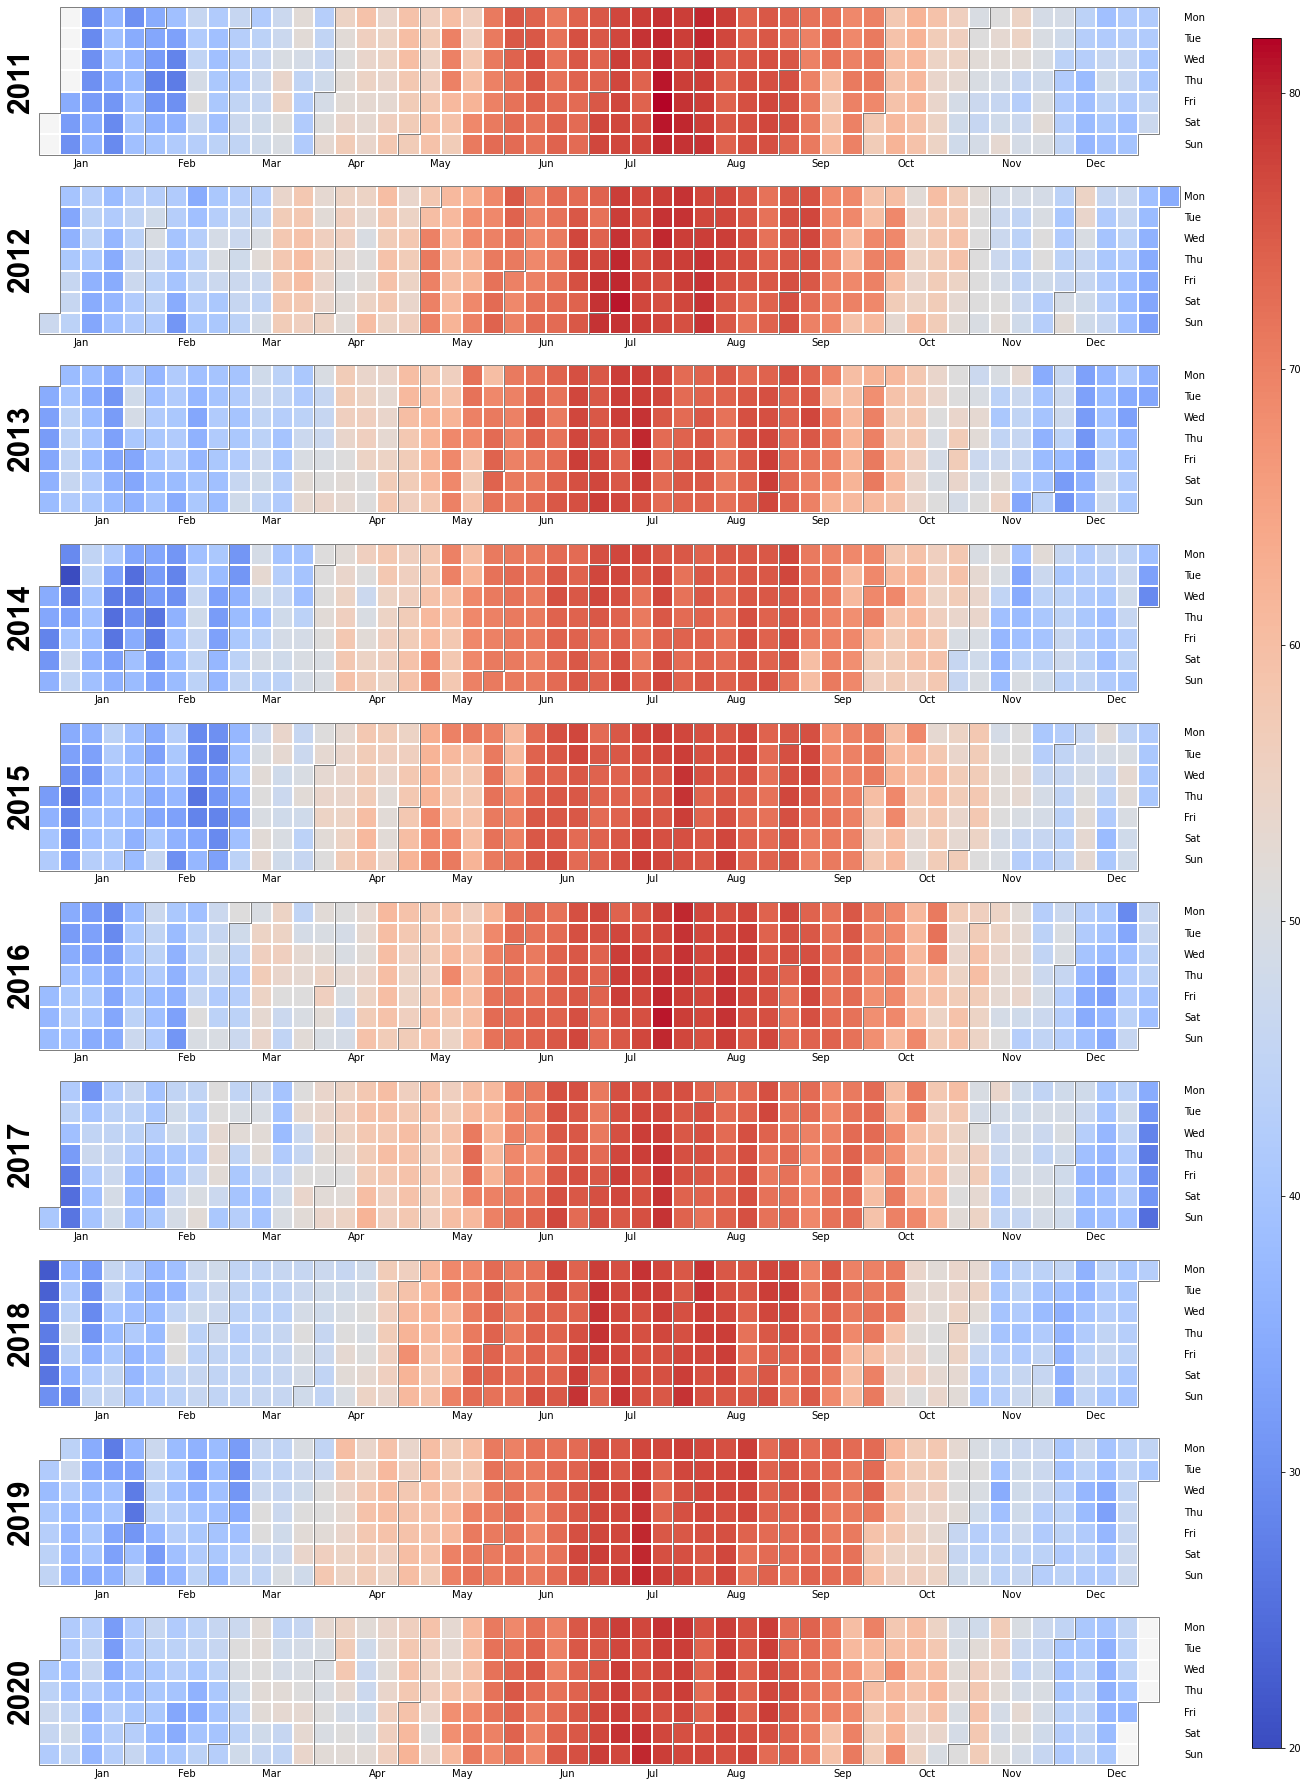

In [26]:
calplot.calplot(data=Temp, cmap='coolwarm', yearcolor='black', figsize=(20,25));

## Simple ARIMA Forecast 

We begin by creating a very basic ARIMA model so we can see if Gluon-TS provides a vast improvement over traditional forecasting techniques.

In [27]:
# split the time series into training and testing sets
series = full_df['Spot'].copy()

### Create Train/Test Split

In [28]:
train_pct = 0.8
split_index = round(len(series)*train_pct)

train = series.iloc[:split_index]
test = series.iloc[split_index:]

#### Auto_Arima Model 

In [29]:
# employs auto_arima library to find optimal p & q values using stepwise method
auto_model = auto_arima(series, start_p=0, start_q=0)

print('Optimal p,d,q: {} x {}'.format(auto_model.order, auto_model.seasonal_order))

Optimal p,d,q: (2, 1, 1) x (0, 0, 0, 0)


#### SARIMAX Model with Optimal Values

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Spot   No. Observations:                 3641
Model:               SARIMAX(2, 1, 1)   Log Likelihood                2653.581
Date:                Tue, 02 Feb 2021   AIC                          -5299.162
Time:                        01:15:27   BIC                          -5274.363
Sample:                    01-07-2011   HQIC                         -5290.329
                         - 12-25-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0070      0.010     98.903      0.000       0.987       1.027
ar.L2         -0.2669      0.003    -80.216      0.000      -0.273      -0.260
ma.L1         -0.8316      0.010    -81.341      0.000      -0.852      -0.812
sigma2         0.0136   5.67e-05    240.423      0.000       0.014       0.014
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):            987462.13
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                            -0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        83.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

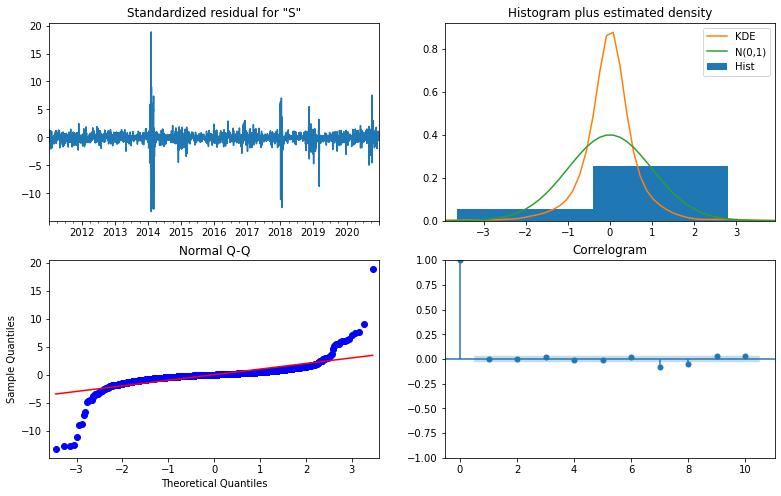

In [116]:
# fit auto_arima model with optimal parameters
best_model = SARIMAX(series, order=auto_model.order, seasonal_order=auto_model.seasonal_order).fit()

display(best_model.summary())

best_model.plot_diagnostics(figsize=(13,8));

In [31]:
def forecast_to_df(model, steps=14):
    forecast = model.get_forecast(steps=steps)
    pred_df = forecast.conf_int()
    pred_df['pred'] = forecast.predicted_mean
    pred_df.columns = ['lower', 'upper', 'pred']
    return pred_df

In [32]:
in_sample_prediction_df = forecast_to_df(best_model, steps=len(test))

prediction = in_sample_prediction_df['pred'] 

# calculate MSE & RMSE
mse = mean_squared_error(prediction, test)
rmse = math.sqrt(mse)

In [119]:
print('RMSE:' + str(rmse))

RMSE:0.5689049309040364


In [34]:
# plot SARIMAX forecast
def plot_train_test_pred(test, pred_df):
    fig,ax = plt.subplots(figsize=(12,7))
    
    ax.plot(test[-54:],label='Price', color='black')
    ax.plot(pred_df['pred'],label='Forecast',ls='-',linewidth=3)
    ax.fill_between(x=pred_df.index, y1=pred_df['lower'], y2=pred_df['upper'], alpha=0.35)
    
    ax.set_title('ARIMA Forecast', fontsize=22)
    
    ax.legend(loc='upper left')
    fig.tight_layout()
    
    return fig,ax

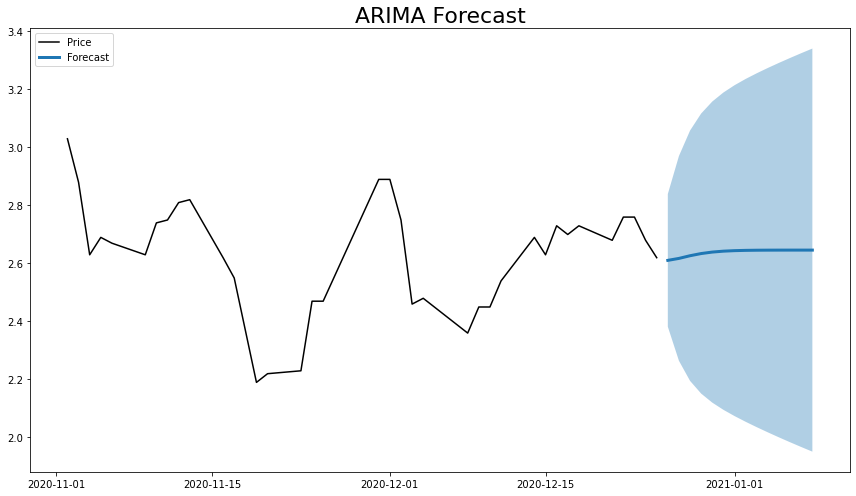

In [130]:
# making a future forecast with the SARIMAX model
forecast_df = forecast_to_df(best_model, steps=14)

plot_train_test_pred(test, forecast_df);

In [131]:
#forecast_df.head(14)

 The ARIMA model has an RMSE of 0.5689 and fairly wide 95% confidence interval bands, spanning between \\$1.95 - \\$3.34 on the final forecasted day.

##  Creating a Gluon-TS Forecast Model

First we specify hyperparameters which will be consistent for all models.

In [37]:
# size of rolling window used to create forecast
context_length = 28

# size of forecast window
prediction_length = 14

# periodicity of forecast points
freq= 'D' 

We establish a base model using default hyperparameters. 

In [38]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions

estimator = DeepAREstimator(freq=freq,
                            num_layers = 2,
                            num_cells = 40,
                            cell_type = 'lstm',
                            context_length=context_length,
                            prediction_length=prediction_length,
                            dropout_rate=0.1,
                            use_feat_dynamic_real=True,
                            
                            trainer=Trainer(epochs=30,
                                            learning_rate=0.001,
                                            batch_size=32
                                            )
                           )

### Creating In-Sample Prediction

First, we create an in-sample prediction using our default model, to test the accuracy of the model and see how it compares to the tuned model.

In [122]:
# creating a training and testing set using Gluon's unique input format
train_ds = ListDataset([{FieldName.TARGET: full_df['Spot'][:-prediction_length],
                         FieldName.FEAT_DYNAMIC_REAL: full_df[['HDD','CDD','CONUS']][:-prediction_length].values.T,
                         FieldName.START: full_df.index[0]}],
                         freq=freq)

test_ds = ListDataset([{FieldName.TARGET: full_df['Spot'],
                         FieldName.FEAT_DYNAMIC_REAL: full_df[['HDD','CDD','CONUS']].values.T,
                         FieldName.START: full_df.index[0]}],
                         freq=freq)

In [40]:
# training the model
predictor = estimator.train(train_ds)

Multiprocessing is not supported on Windows, num_workers will be set to None.
  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|███████████████████████████████████████████████| 50/50 [00:06<00:00,  8.26it/s, epoch=30/30, avg_epoch_loss=-.179]


### Evaluating the Model 

In [123]:
# check how the probabilistic model performs
forecast_it, ts_it = make_evaluation_predictions(
                                                dataset=test_ds,  # test dataset
                                                predictor=predictor,  # predictor
                                                num_samples=100)  # number of sample paths for evaluation

In [124]:
print(forecast_it)

<generator object GluonPredictor.predict at 0x000001681BD0FC80>


In [43]:
# turn time series and prediction generator objects into lists
forecasts = list(forecast_it)
tss = list(ts_it)

In [44]:
# first entry of the time series
ts_entry = tss[0]

# first entry of the prediction
forecast_entry = forecasts[0]

In [45]:
#print(forecasts)

In [46]:
print(f'Number of sample paths: {forecast_entry.num_samples}')
print(f'Dimension of samples: {forecast_entry.samples.shape}')
print(f'Start date of the prediction window: {forecast_entry.start_date}')
print(f'Frequency of the time series: {forecast_entry.freq}')

Number of sample paths: 100
Dimension of samples: (100, 14)
Start date of the prediction window: 2020-12-12 00:00:00
Frequency of the time series: D


In [47]:
print(f'Median of the in-sample prediction window:\n {forecast_entry.median}')

Median of the in-sample prediction window:
 [2.480588  2.4946496 2.501759  2.5087016 2.4442132 2.4534707 2.5330427
 2.4692953 2.4639993 2.4747972 2.51218   2.4748032 2.5284348 2.4917705]


In [48]:
def get_all_samples(forecast):
    samples = forecast.samples
    num_samples, forecast_horizon = samples.shape
    
    dates = pd.date_range(forecast.start_date, freq=forecast.freq, periods=forecast_horizon)
    
    return pd.DataFrame(samples.T, index=dates)

In [49]:
all_samples = get_all_samples(forecast_entry)

all_samples.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2020-12-12,2.291371,2.625158,2.681733,2.280867,2.615777,2.576288,2.620498,2.236975,2.620402,2.560346,...,2.548460,2.190060,2.658780,2.247535,2.624371,2.070701,2.595006,2.494253,3.365227,2.045289
2020-12-13,2.473328,2.926531,2.348537,2.725566,2.097245,2.318937,2.284194,1.939085,2.599311,1.893750,...,-1.000598,1.920636,2.435282,2.714899,2.560971,2.465666,2.458479,2.748677,3.032295,2.840715
2020-12-14,2.469470,2.206188,2.672863,2.648733,2.886476,3.067716,2.460515,3.125634,2.634699,2.607658,...,2.620145,2.623713,2.486210,2.495874,2.181631,1.778560,2.672214,3.160636,2.628865,2.412021
2020-12-15,2.508634,2.019735,1.861534,2.215560,2.491517,2.677947,2.664739,2.645170,2.295083,2.200495,...,2.209677,2.431650,2.841385,2.896998,2.250627,2.355291,2.316282,2.263659,2.185372,2.414326
2020-12-16,2.621383,2.605390,2.485101,2.400985,2.476512,2.109439,2.547670,2.279104,2.535284,2.437908,...,2.125133,2.587687,2.804332,2.205228,2.386315,2.357404,2.772445,2.845049,1.339506,2.479160


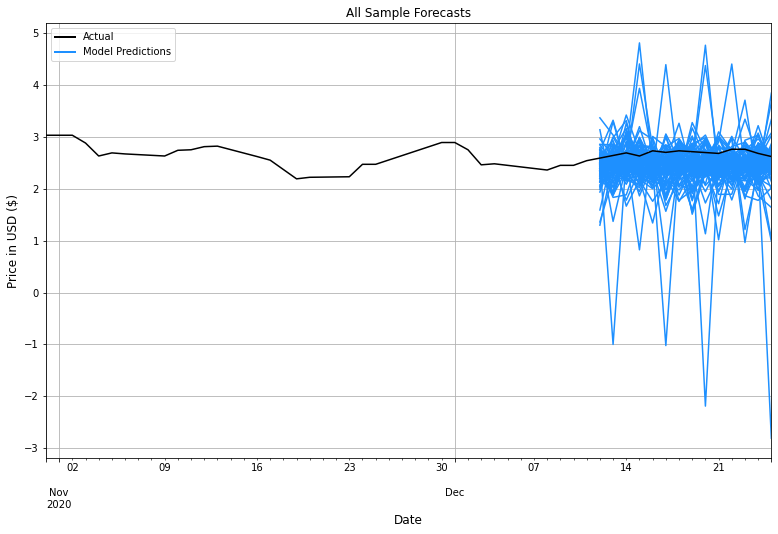

In [50]:
from matplotlib.lines import Line2D

plot_length = 56
    
ax = full_df['Spot'][-plot_length:].plot(color='black', zorder=10)  # plot the time series
all_samples.plot(ax=ax, color='dodgerblue') #plot all the samples from the forecast

ax.set_ylabel('Price in USD ($)', fontsize=12)
ax.set_xlabel('Date', fontsize=12)

plt.title('All Sample Forecasts')
plt.grid(which='major')

custom_lines = [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='dodgerblue', lw=2)]

ax.legend(custom_lines, ['Actual', 'Model Predictions'])

plt.show();

Next we turn the 100 sample predictions into confidence intervals based on their distribution.

In [51]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    
    plot_length = 56
    
    prediction_intervals = (50.0, 95.0)
    legend = ['observed price', 'median prediction'] + [f'{i}% prediction interval' for i in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax, color='black')  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='dodgerblue')
    plt.title('In-Sample Prediction')
    plt.grid(which='major')
    plt.legend(legend, loc='upper left')
    plt.show()

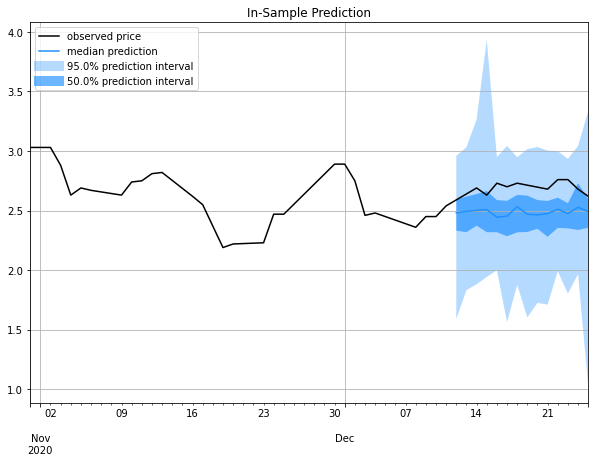

In [52]:
plot_prob_forecasts(ts_entry, forecast_entry)

In [53]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.98it/s]


In [54]:
print('RMSE:' + json.dumps(agg_metrics['RMSE'], indent=2))

RMSE:0.2329662126441521


### Creating a Future Forecast 

 To create a future forecast, we need to extend the exogenous variables into the forecast window. We could generate these variables using a multivariate forecast, but instead choose to obtain these values from external sources to provide a more crisp model.

In [55]:
from current_weather_grabber import *

In [56]:
scrape_weather()

In [127]:
# gather weather forecast from TrueWX using selenium
current_weather = pd.read_csv('current_weather.csv', index_col=0, parse_dates=True)

future_forecast = full_df.append(current_weather)

In [58]:
# use forecasted storage values from the EIA dashboard
future_forecast.at['2021-01-01', 'CONUS'] = 3139
future_forecast.at['2021-01-08', 'CONUS'] = 2978
future_forecast.drop(['Temp','Base_Temp','Year'], axis=1, inplace=True)
future_forecast['CONUS'] = future_forecast['CONUS'].interpolate()

In [126]:
# append these values to the initial dataframe
future_forecast.tail(14)

,HDD,CDD,CONUS,Spot
2020-12-26,25.51,0.03,3414.142857,NaN
2020-12-27,24.77,0.03,3368.285714,NaN
2020-12-28,22.47,0.16,3322.428571,NaN
2020-12-29,25.39,0.14,3276.571429,NaN
2020-12-30,29.16,0.24,3230.714286,NaN
2020-12-31,36.95,0.39,3184.857143,NaN
2021-01-01,41.35,0.07,3139.000000,NaN
2021-01-02,35.06,0.05,3116.000000,NaN
2021-01-03,32.82,0.25,3093.000000,NaN
2021-01-04,37.19,0.28,3070.000000,NaN


In [128]:
# convert the dataframe in Gluon-TS compatible format
forecast_train = ListDataset([{FieldName.TARGET: future_forecast['Spot'][:-prediction_length],
                         FieldName.FEAT_DYNAMIC_REAL: future_forecast[['HDD','CDD','CONUS']][:-prediction_length].values.T,
                         FieldName.START: future_forecast.index[0]}],
                         freq=freq)

forecast_test = ListDataset([{FieldName.TARGET: future_forecast['Spot'][:-prediction_length],
                         FieldName.FEAT_DYNAMIC_REAL: future_forecast[['HDD','CDD','CONUS']].values.T,
                         FieldName.START: future_forecast.index[0]}],
                         freq=freq)

In [61]:
forecast_future = estimator.train(forecast_train)

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|███████████████████████████████████████████████| 50/50 [00:06<00:00,  7.93it/s, epoch=30/30, avg_epoch_loss=-.169]


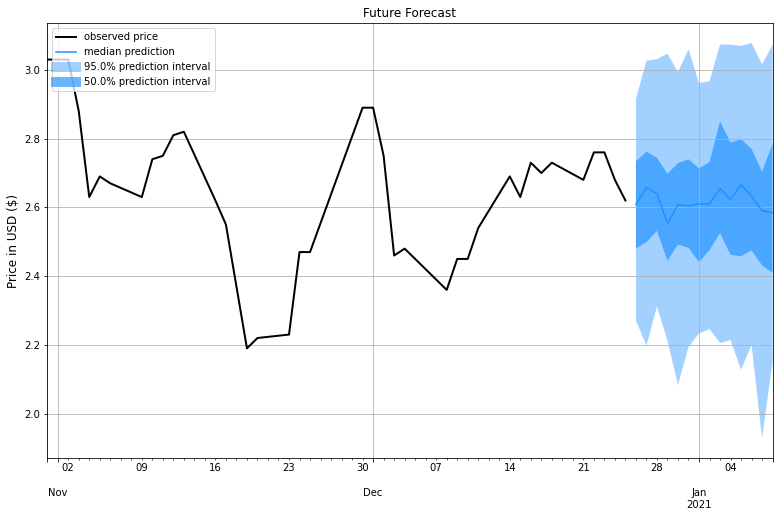

In [62]:
for test_entry, forecast in zip(forecast_test, forecast_future.predict(forecast_test)):
    
    to_pandas(test_entry)[-56:].plot(linewidth=2, color='black')
    forecast.plot(color='dodgerblue', prediction_intervals=[50.0, 90.0])
    
    prediction_intervals = (50.0, 95.0)
    legend = ['observed price', 'median prediction'] + [f'{i}% prediction interval' for i in prediction_intervals][::-1]
    
    plt.title('Future Forecast')
    plt.ylabel('Price in USD ($)', fontsize=12)
    plt.grid(which='major')
    plt.legend(legend, loc='upper left')

In [63]:
forecast_future_ = list(forecast_future.predict(forecast_test))
forecast_entry_future = forecast_future_[0]

print(f'Median of the future forecast window:\n {forecast_entry_future.median}')

Median of the future forecast window:
 [2.624252  2.616652  2.5989418 2.6259103 2.5883667 2.6620886 2.644296
 2.6083732 2.6236637 2.6250587 2.5728478 2.6366107 2.5451725 2.6236937]


### Adapting the Dataset for Sagemaker's Hyperparameter Tuner 

In [64]:
datasets = TrainDatasets(
                         metadata=MetaData(
                                          freq=freq,
                                          target={'name': 'Spot'},
                                          prediction_length = prediction_length),
    
                         train=train_ds,
                         test=test_ds

                        )

In [65]:
bucket = 'output_bucket'
prefix = 'model-tuning'
dataset_name = f'natural-gas-data'

#%set_env BUCKET=$bucket
#%set_env PREFIX=$prefix
#%set_env DATASET_NAME=$dataset_name

In [66]:
local_path=f'../data/{dataset_name}'

TrainDatasets.save(datasets,
    path_str=local_path,
    overwrite=True)

In [67]:
reloaded_dataset = load_datasets(
                        metadata=os.path.join(local_path, "metadata"),
                        train=os.path.join(local_path, "train"),
                        test=os.path.join(local_path, "test")
                   )
display(reloaded_dataset.metadata,
        reloaded_dataset.train,
        reloaded_dataset.test)

MetaData(freq='D', target=BasicFeatureInfo(name='Spot'), feat_static_cat=[], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=14)

## Tuned Model

In [68]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions

estimator_tuned = DeepAREstimator(freq=freq,
                            num_layers = 4,
                            num_cells = 44,
                            cell_type = 'lstm',
                            context_length=context_length,
                            prediction_length=prediction_length,
                            dropout_rate=0.46032325741405156,
                            use_feat_dynamic_real=True,
                            
                            trainer=Trainer(epochs=30,
                                            learning_rate=0.0025475023833545288,
                                            batch_size=32
                                            )
                           )

### Tuned In-Sample Prediction 

In [69]:
predictor_tuned = estimator_tuned.train(train_ds)

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|███████████████████████████████████████████████| 50/50 [00:08<00:00,  5.84it/s, epoch=30/30, avg_epoch_loss=-.172]


In [70]:
forecast_it_tuned, ts_it_tuned = make_evaluation_predictions(
                                                dataset=test_ds,  # test dataset
                                                predictor=predictor_tuned,  # predictor
                                                num_samples=100)  # number of sample paths for evaluation

In [71]:
forecasts_tuned = list(forecast_it_tuned)
tss_tuned = list(ts_it_tuned)

In [72]:
# first entry of the time series list
ts_entry_tuned = tss_tuned[0]

# first entry of the tuned prediction list
forecast_entry_tuned = forecasts_tuned[0]

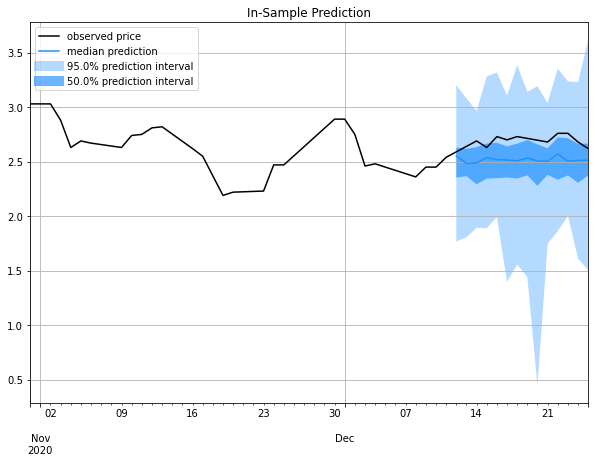

In [73]:
plot_prob_forecasts(ts_entry_tuned, forecast_entry_tuned)

## Evaluating the Tuned Model 

In [74]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics_tuned, item_metrics = evaluator(iter(tss_tuned), iter(forecasts_tuned), num_series=len(test_ds))

Running evaluation: 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.76it/s]


In [75]:
print('RMSE:' + json.dumps(agg_metrics_tuned['RMSE'], indent=2))

RMSE:0.19679787524296943


## Tuned Future Forecast 

In [76]:
forecast_future_tuned = estimator_tuned.train(forecast_train)

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|███████████████████████████████████████████████| 50/50 [00:08<00:00,  5.78it/s, epoch=30/30, avg_epoch_loss=-.173]


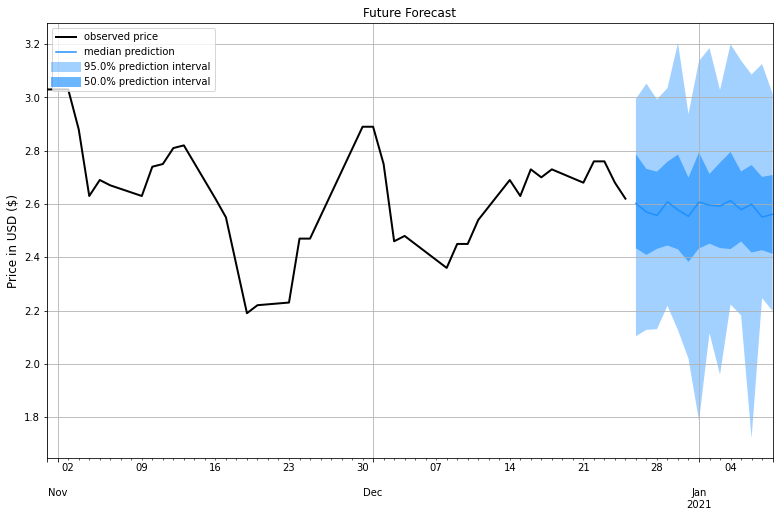

In [77]:
for test_entry, forecast in zip(forecast_test, forecast_future_tuned.predict(forecast_test)):
    
    to_pandas(test_entry)[-56:].plot(linewidth=2, color='black')
    forecast.plot(color='dodgerblue', prediction_intervals=[50.0, 90.0])
    
    prediction_intervals = (50.0, 95.0)
    legend = ['observed price', 'median prediction'] + [f'{i}% prediction interval' for i in prediction_intervals][::-1]
    
    plt.title('Future Forecast')
    plt.ylabel('Price in USD ($)', fontsize=12)
    plt.grid(which='major')
    plt.legend(legend, loc='upper left')

In [78]:
forecasts_tuned = list(forecast_future_tuned.predict(forecast_test))
forecast_entry_tuned = forecasts_tuned[0]

print(f'Median of the out-of-sample forecast window:\n {forecast_entry_tuned.median}')

Median of the out-of-sample forecast window:
 [2.667521  2.5994952 2.6269515 2.580753  2.5670028 2.5816598 2.5571952
 2.5943556 2.5641313 2.6278813 2.582467  2.5915468 2.5860333 2.5546973]


## Conclusion/Recommendations

The tuned model performed much better than either the ARIMA model or Gluon-TS with default hyperparameters. Below is each model and it's corresponding RMSE.

|      |  ARIMA | default Gluon-TS | tuned Gluon-TS |
|------|:------:|:----------------:|:--------------:|
| RMSE | 0.5689 |      0.2330      |     0.1968     |

The final Gluon-TS model indicates that the price of natural gas will slightly decline over the next two weeks. It could be profitable to open a short position on natural gas, monitoring any changes to the underlying weather/storage assumptions. 